<a href="https://colab.research.google.com/github/awmoawad/fastbook/blob/master/AWM_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and modules to be imported

In [1]:
#hide
!pip install torchtext==0.8.1b
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 7.0MB 5.5MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0
     |████████████████████████████████| 727kB 5.8MB/s 
     |████████████████████████████████| 194kB 15.5MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 18.0MB/s 
     |████████████████████████████████| 12.8MB 209kB/s 
     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
Mounted at /content/gdrive


In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [6]:
my_key = "727b6276db454b90832e46389c4d3991"

In [7]:
key = os.environ.get('AZURE_SEARCH_KEY', my_key)

Once you've set `key`, you can use `search_images_bing`. This function is provided by the small `utils` class included with the notebooks online. If you're not sure where a function is defined, you can just type it in your notebook to find out:

In [8]:
search_images_bing

<function fastbook.search_images_bing>

In [123]:
results = search_images_bing(key, 'chestxray')
ims = results.attrgot('content_url')
len(ims)

150

In [40]:
ims = ['https://images.radiopaedia.org/images/157210/332aa0c67cb2e035e372c7cb3ceca2.jpg']

In [41]:
dest = './chest.jpg'
download_url(ims[0], dest)

In [ ]:
# to check your current directory
from os import getcwd
getcwd()

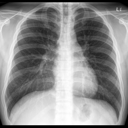

In [43]:
im = Image.open(dest)
im.to_thumb(128,128)

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

### *A very good classification practice is to locate each class in specific folder.* 

In [124]:
# study types and path should include word that is Probably to be included in the URL / picture description
study_types = 'anterior','lateral'
path = Path('chest_xray')

In [125]:
if not path.exists():
    path.mkdir()
    for o in study_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'chestxray {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [126]:
fns = get_image_files(path)
fns

(#269) [Path('chest_xray/lateral/00000020.jpg'),Path('chest_xray/lateral/00000071.jpg'),Path('chest_xray/lateral/00000008.jpg'),Path('chest_xray/lateral/00000138.jpg'),Path('chest_xray/lateral/00000021.jpg'),Path('chest_xray/lateral/00000135.jpg'),Path('chest_xray/lateral/00000107.jpg'),Path('chest_xray/lateral/00000118.ppm'),Path('chest_xray/lateral/00000129.jpg'),Path('chest_xray/lateral/00000024.jpg')...]

In [127]:
failed = verify_images(fns)
failed

(#0) []

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [128]:
failed.map(Path.unlink);

In [ ]:
#use this doc function to determine the docs of certain function.
doc(fn_name)

Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

In [129]:
chest_xray = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

- we passed seed as 42 to ensure consistency of our validation set.
- we used get_y as we want to predict the label not the data. 

In [130]:
dls = chest_xray.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#to avoid croping and use stretching instead
chestrad_stretch = chest_xray.new(item_tfms=Resize(128, ResizeMethod.Squish))
#chestrad_pad = chest_xray.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = chest_xray.dataloaders(path)
dls.valid.show_batch(max_n=40, nrows=5)